In [ ]:
import eddy_footprint as ef
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from sublimpy import utils, extrautils
import swifter

In [ ]:
ls ../paper1/process_slow_data | grep parquet

In [ ]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"

In [ ]:
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().reset_index()

In [ ]:
tidy_df = tidy_df[(tidy_df.time > '20230510') & (tidy_df.time < '20230518')]

In [ ]:
tidy_df_streamwise = tidy_df.swifter.groupby('time').apply(extrautils.streamwise_coordinates_single_rotation_tidy_df)
tidy_df_streamwise = tidy_df_streamwise.reset_index(drop=True)

In [ ]:
footprint_inputs_table = tidy_df_streamwise[tidy_df_streamwise.variable.isin([
    'P_10m_c',
    
    'T_3m_c',   'u*_3m_c',  'spd_3m_c',  'v_v_3m_c',  'dir_3m_c',  'L_3m_c',  'v_v__3m_c',
    'T_5m_c',   'u*_5m_c',  'spd_5m_c',  'v_v_5m_c',  'dir_5m_c',  'L_5m_c',  'v_v__5m_c',
    'T_10m_c',  'u*_10m_c', 'spd_10m_c', 'v_v_10m_c', 'dir_10m_c', 'L_10m_c', 'v_v__10m_c',
    'T_15m_c',  'u*_15m_c', 'spd_15m_c', 'v_v_15m_c', 'dir_15m_c', 'L_15m_c', 'v_v__15m_c',
    'T_20m_c',  'u*_20m_c', 'spd_20m_c', 'v_v_20m_c', 'dir_20m_c', 'L_20m_c', 'v_v__20m_c',

    'u*_3m_d', 'spd_3m_d', 'v_v_3m_d', 'dir_3m_d', 'L_3m_d', 'v_v__3m_d',
    'u*_3m_ue', 'spd_3m_ue', 'v_v_3m_ue', 'dir_3m_ue', 'L_3m_ue', 'v_v__3m_ue',
    'u*_3m_uw', 'spd_3m_uw', 'v_v_3m_uw', 'dir_3m_uw', 'L_3m_uw', 'v_v__3m_uw',

    'u*_10m_d', 'spd_10m_d', 'v_v_10m_d', 'dir_10m_d', 'L_10m_d', 'v_v__10m_d',
    'u*_10m_ue', 'spd_10m_ue', 'v_v_10m_ue', 'dir_10m_ue', 'L_10m_ue', 'v_v__10m_ue',
    'u*_10m_uw', 'spd_10m_uw', 'v_v_10m_uw', 'dir_10m_uw', 'L_10m_uw', 'v_v__10m_uw',

    'SnowDepth_c',
])].pivot_table(
    index='time', 
    columns='variable', 
    values = 'value'
)

footprint_inputs_table.head(3)

# Using footprint.kljun.net/download_2.php

In [ ]:

# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

In [ ]:
src = footprint_inputs_table
src_stable = src[src.index.isin(ri_stable_times)]
src_unstable = src[src.index.isin(ri_unstable_times)]
src_neutral = src[src.index.isin(ri_neutral_times)]
src_upvalley = src[src.index.isin(upvalley_wind_times)]
src_downvalley = src[src.index.isin(downvalley_wind_times)]

In [ ]:
len(src),len(src_stable) + len(src_unstable) + len(src_neutral), len(src_stable), len(src_unstable), len(src_neutral)

In [ ]:
import FFP_Python.calc_footprint_FFP_climatology as footprint_clim
from matplotlib.colors import LogNorm

In [22]:
results_3m_all = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0079,
    umean    = list(src['spd_3m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_3m_c'].values),
    sigmav   = list(src['v_v__3m_c'].values),
    ustar    = list(src['u*_3m_c'].values),
    wind_dir = list(src['dir_3m_c'].values),
    fs = 0.9,
    verbosity=1
)

In [ ]:

results_5m_all = footprint_clim.FFP_climatology(
    zm       = 5,
    z0       = 0.0001,
    umean    = list(src['spd_5m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_5m_c'].values),
    sigmav   = list(src['v_v__5m_c'].values),
    ustar    = list(src['u*_5m_c'].values),
    wind_dir = list(src['dir_5m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_10m_all = footprint_clim.FFP_climatology(
    zm       = 10,
    z0       = 0.0001,
    umean    = list(src['spd_10m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_10m_c'].values),
    sigmav   = list(src['v_v__10m_c'].values),
    ustar    = list(src['u*_10m_c'].values),
    wind_dir = list(src['dir_10m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_15m_all = footprint_clim.FFP_climatology(
    zm       = 15,
    z0       = 0.0001,
    umean    = list(src['spd_15m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_15m_c'].values),
    sigmav   = list(src['v_v__15m_c'].values),
    ustar    = list(src['u*_15m_c'].values),
    wind_dir = list(src['dir_15m_c'].values),
    fs = 0.75,
    verbosity=1
)


results_20m_all = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src['spd_20m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_20m_c'].values),
    sigmav   = list(src['v_v__20m_c'].values),
    ustar    = list(src['u*_20m_c'].values),
    wind_dir = list(src['dir_20m_c'].values),
    fs = 0.75,
    verbosity=1
)


In [19]:
results_3m_all.keys()

dict_keys(['x_2d', 'y_2d', 'fclim_2d', 'rs', 'fr', 'xr', 'yr', 'n', 'flag_err'])

In [23]:
results_3m_all['rs']

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

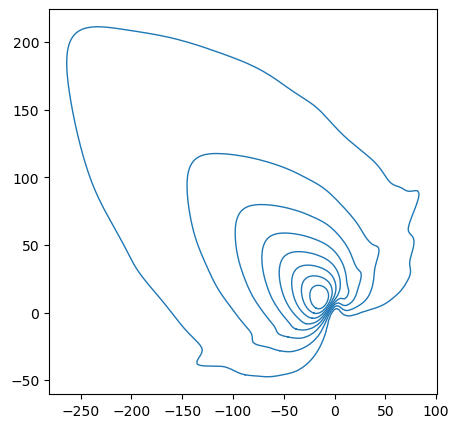

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
for xr, yr in list(zip(results_3m_all['xr'], results_3m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:blue', linewidth=1.0, label='3m')

In [36]:
results_3m_all['rs']

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

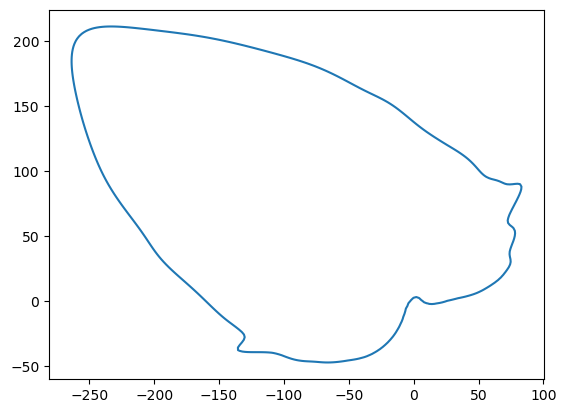

In [37]:
from shapely.geometry import LineString
import geopandas as gpd
points = list(zip(results_3m_all['xr'][-1], results_3m_all['yr'][-1]))

# Create a LineString from the points
gdf = gpd.GeoDataFrame(geometry = [LineString(points)])
gdf.plot()
gdf.to_file('footprint_3m_ec_20230510_to_20230517_80percent.geojson')

NameError: name 'results_5m_all' is not defined

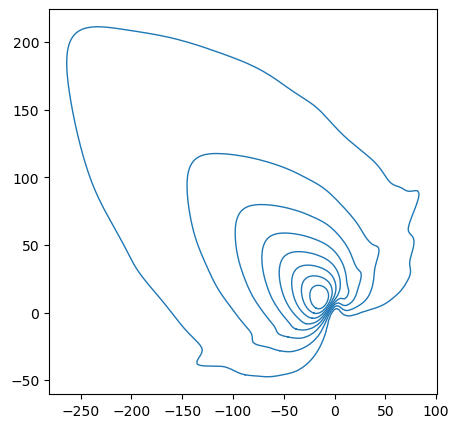

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
for xr, yr in list(zip(results_3m_all['xr'], results_3m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:blue', linewidth=1.0, label='3m')
for xr, yr in list(zip(results_5m_all['xr'], results_5m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:green', linewidth=1.0, label='5m')
for xr, yr in list(zip(results_10m_all['xr'], results_10m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:orange', linewidth=1.0, label='10m')
for xr, yr in list(zip(results_15m_all['xr'], results_15m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:red', linewidth=1.0, label='15m')
for xr, yr in list(zip(results_20m_all['xr'], results_20m_all['yr'])):
    if xr and yr:
        ax.plot(xr, yr, color='tab:purple', linewidth=1.0, label='20m')
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

In [ ]:
import xarray as xr

In [ ]:
results_3m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_3m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_3m_c'].values),
    sigmav   = list(src_unstable['v_v__3m_c'].values),
    ustar    = list(src_unstable['u*_3m_c'].values),
    wind_dir = list(src_unstable['dir_3m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_3m_stable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_stable['spd_3m_c'].values),
    h        = list(np.full(len(src_stable), 600)),
    ol       = list(src_stable['L_3m_c'].values),
    sigmav   = list(src_stable['v_v__3m_c'].values),
    ustar    = list(src_stable['u*_3m_c'].values),
    wind_dir = list(src_stable['dir_3m_c'].values),
    fs = 0.75
)

results_3m_neutral = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_neutral['spd_3m_c'].values),
    h        = list(np.full(len(src_neutral), 600)),
    ol       = list(src_neutral['L_3m_c'].values),
    sigmav   = list(src_neutral['v_v__3m_c'].values),
    ustar    = list(src_neutral['u*_3m_c'].values),
    wind_dir = list(src_neutral['dir_3m_c'].values),
    fs = 0.75
)

results_3m_upvalley = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_upvalley['spd_3m_c'].values),
    h        = list(np.full(len(src_upvalley), 600)),
    ol       = list(src_upvalley['L_3m_c'].values),
    sigmav   = list(src_upvalley['v_v__3m_c'].values),
    ustar    = list(src_upvalley['u*_3m_c'].values),
    wind_dir = list(src_upvalley['dir_3m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_3m_downvalley = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_downvalley['spd_3m_c'].values),
    h        = list(np.full(len(src_downvalley), 600)),
    ol       = list(src_downvalley['L_3m_c'].values),
    sigmav   = list(src_downvalley['v_v__3m_c'].values),
    ustar    = list(src_downvalley['u*_3m_c'].values),
    wind_dir = list(src_downvalley['dir_3m_c'].values),
    fs = 0.75
)


In [ ]:
results_3m = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src['spd_3m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_3m_c'].values),
    sigmav   = list(src['v_v__3m_c'].values),
    ustar    = list(src['u*_3m_c'].values),
    wind_dir = list(src['dir_3m_c'].values),
    fs = 0.75
)


In [ ]:
results_20m = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src['spd_20m_c'].values),
    h        = list(np.full(len(src), 600)),
    ol       = list(src['L_20m_c'].values),
    sigmav   = list(src['v_v__20m_c'].values),
    ustar    = list(src['u*_20m_c'].values),
    wind_dir = list(src['dir_20m_c'].values),
)

In [ ]:
results_20m_unstable = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_20m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_20m_c'].values),
    sigmav   = list(src_unstable['v_v__20m_c'].values),
    ustar    = list(src_unstable['u*_20m_c'].values),
    wind_dir = list(src_unstable['dir_20m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_20m_stable = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src_stable['spd_20m_c'].values),
    h        = list(np.full(len(src_stable), 600)),
    ol       = list(src_stable['L_20m_c'].values),
    sigmav   = list(src_stable['v_v__20m_c'].values),
    ustar    = list(src_stable['u*_20m_c'].values),
    wind_dir = list(src_stable['dir_20m_c'].values),
    fs = 0.75
)

results_20m_neutral = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src_neutral['spd_20m_c'].values),
    h        = list(np.full(len(src_neutral), 600)),
    ol       = list(src_neutral['L_20m_c'].values),
    sigmav   = list(src_neutral['v_v__20m_c'].values),
    ustar    = list(src_neutral['u*_20m_c'].values),
    wind_dir = list(src_neutral['dir_20m_c'].values),
    fs = 0.75
)

results_20m_upvalley = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src_upvalley['spd_20m_c'].values),
    h        = list(np.full(len(src_upvalley), 600)),
    ol       = list(src_upvalley['L_20m_c'].values),
    sigmav   = list(src_upvalley['v_v__20m_c'].values),
    ustar    = list(src_upvalley['u*_20m_c'].values),
    wind_dir = list(src_upvalley['dir_20m_c'].values),
    fs = 0.75,
    verbosity=1
)

results_20m_downvalley = footprint_clim.FFP_climatology(
    zm       = 20,
    z0       = 0.0001,
    umean    = list(src_downvalley['spd_20m_c'].values),
    h        = list(np.full(len(src_downvalley), 600)),
    ol       = list(src_downvalley['L_20m_c'].values),
    sigmav   = list(src_downvalley['v_v__20m_c'].values),
    ustar    = list(src_downvalley['u*_20m_c'].values),
    wind_dir = list(src_downvalley['dir_20m_c'].values),
    fs = 0.75
)


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)

for xr, yr in list(zip(results_3m_all['xr'], results_3m_all['yr'])):
    axes[0].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_all['xr'], results_20m_all['yr'])): 
    axes[0].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[0].set_title('Stable')

for xr, yr in list(zip(results_3m_neutral['xr'], results_3m_neutral['yr'])):
    axes[1].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_neutral['xr'], results_20m_neutral['yr'])):
    axes[1].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[1].set_title('Neutral')

for xr, yr in list(zip(results_3m_all['xr'], results_3m_all['yr'])):
    axes[2].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_all['xr'], results_20m_all['yr'])):
    axes[2].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[2].set_title('Unall')

# for xr, yr in list(zip(results_3m['xr'], results_3m['yr']))[:-3] :
#     axes[0].plot(xr, yr, color='tab:blue', linewidth=0.5)
# for xr, yr in list(zip(results_20m['xr'], results_20m['yr']))[:-3] :
#     axes[0].plot(xr, yr, color='tab:orange', linewidth=0.5)
# axes[0].set_title('All data')

for ax in axes:
    # ax.legend()
    ax.set_aspect('equal')
    ax.scatter([0],[0], color='black')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='tab:orange', lw=1)]

axes[0].legend(custom_lines, ['3m', '20m'])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,8), sharex=True, sharey=True)

for xr, yr in list(zip(results_3m_stable['xr'], results_3m_stable['yr'])):
    axes[0].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_stable['xr'], results_20m_stable['yr'])): 
    axes[0].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[0].set_title('Stable')

for xr, yr in list(zip(results_3m_neutral['xr'], results_3m_neutral['yr'])):
    axes[1].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_neutral['xr'], results_20m_neutral['yr'])):
    axes[1].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[1].set_title('Neutral')

for xr, yr in list(zip(results_3m_unstable['xr'], results_3m_unstable['yr'])):
    axes[2].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_unstable['xr'], results_20m_unstable['yr'])):
    axes[2].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[2].set_title('Unstable')

# for xr, yr in list(zip(results_3m['xr'], results_3m['yr']))[:-3] :
#     axes[0].plot(xr, yr, color='tab:blue', linewidth=0.5)
# for xr, yr in list(zip(results_20m['xr'], results_20m['yr']))[:-3] :
#     axes[0].plot(xr, yr, color='tab:orange', linewidth=0.5)
# axes[0].set_title('All data')

for ax in axes:
    # ax.legend()
    ax.set_aspect('equal')
    ax.scatter([0],[0], color='black')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='tab:orange', lw=1)]

axes[0].legend(custom_lines, ['3m', '20m'])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,8), sharex=True, sharey=True)

for xr, yr in list(zip(results_3m_downvalley['xr'], results_3m_downvalley['yr'])):
    axes[0].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_downvalley['xr'], results_20m_downvalley['yr'])): 
    if xr is not None and yr is not None:
        axes[0].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[0].set_title('Downvalley')

for xr, yr in list(zip(results_3m_upvalley['xr'], results_3m_upvalley['yr'])):
    if xr is not None and yr is not None:
        axes[1].plot(xr, yr, color='tab:blue', linewidth=0.5)
for xr, yr in list(zip(results_20m_upvalley['xr'], results_20m_upvalley['yr'])): 
    if xr is not None and yr is not None:
        axes[1].plot(xr, yr, color='tab:orange', linewidth=0.5)
axes[1].set_title('Upvalley')


for ax in axes:
    # ax.legend()
    ax.set_aspect('equal')
    ax.scatter([0],[0], color='black')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='tab:orange', lw=1)]

axes[0].legend(custom_lines, ['3m', '20m'])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,8), sharex=True, sharey=True)
axes[0].plot(results_3m_downvalley['xr'][6], results_3m_downvalley['yr'][6], color='tab:blue', linewidth=0.5)
axes[0].plot(results_20m_downvalley['xr'][6], results_20m_downvalley['yr'][6], color='tab:orange', linewidth=0.5)
axes[0].set_title('Downvalley')

axes[1].plot(results_3m_upvalley['xr'][6], results_3m_upvalley['yr'][6], color='tab:blue', linewidth=0.5)
axes[1].plot(results_20m_upvalley['xr'][6], results_20m_upvalley['yr'][6], color='tab:orange', linewidth=0.5)
axes[1].set_title('Upvalley')

for ax in axes:
    # ax.legend()
    ax.set_aspect('equal')
    ax.scatter([0],[0], color='black')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='tab:blue', lw=1),
                Line2D([0], [0], color='tab:orange', lw=1)]

axes[0].legend(custom_lines, ['3m', '20m'])

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10,4), sharex=True, sharey=True)
axes[0].plot(results_3m['xr'][4],            results_3m['yr'][4], label='3m')
axes[0].plot(results_20m['xr'][4],           results_20m['yr'][4], label='20m')
axes[0].set_title('All data')

axes[1].plot(results_3m_stable['xr'][4],     results_3m_stable['yr'][4], label='3m')
axes[1].plot(results_20m_stable['xr'][4],    results_20m_stable['yr'][4], label='20m')
axes[1].set_title('Stable')

axes[2].plot(results_3m_neutral['xr'][4],    results_3m_neutral['yr'][4], label='3m')
axes[2].plot(results_20m_neutral['xr'][4],   results_20m_neutral['yr'][4], label='20m')
axes[2].set_title('Neutral')

axes[3].plot(results_3m_unstable['xr'][4],   results_3m_unstable['yr'][4], label='3m')
axes[3].plot(results_20m_unstable['xr'][4],  results_20m_unstable['yr'][4], label='20m')
axes[3].set_title('Unstable')

for ax in axes:
    ax.legend()

In [ ]:
results_3m_all.keys()

In [ ]:
fig, ax = footprint_clim.plot_footprint(
    results_3m_stable['x_2d'], 
    results_3m_stable['y_2d'], 
    results_3m_stable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('3m stable')
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_3m_neutral['x_2d'], 
    results_3m_neutral['y_2d'], 
    results_3m_neutral['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('3m neutral')
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_3m_unstable['x_2d'], 
    results_3m_unstable['y_2d'], 
    results_3m_unstable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('3m unstable')
plt.show()

In [ ]:
fig, ax = footprint_clim.plot_footprint(
    results_20m_stable['x_2d'], 
    results_20m_stable['y_2d'], 
    results_20m_stable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('20m stable')
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_20m_neutral['x_2d'], 
    results_20m_neutral['y_2d'], 
    results_20m_neutral['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('20m neutral')
plt.show()

fig, ax = footprint_clim.plot_footprint(
    results_20m_unstable['x_2d'], 
    results_20m_unstable['y_2d'], 
    results_20m_unstable['fclim_2d'], 
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('20m unstable')
plt.show()

In [ ]:
src = footprint_inputs_table
src_stable = src[src.index.isin(ri_stable_times)]
src_unstable = src[src.index.isin(ri_unstable_times)]
src_neutral = src[src.index.isin(ri_neutral_times)]


In [ ]:
src = footprint_inputs_table
src_stable = src[src.index.isin(ri_stable_times)]
src_unstable = src[src.index.isin(ri_unstable_times)]
src_neutral = src[src.index.isin(ri_neutral_times)]

results_3m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_3m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_3m_c'].values),
    sigmav   = list(src_unstable['v_v__3m_c'].values),
    ustar    = list(src_unstable['u*_3m_c'].values),
    wind_dir = list(src_unstable['dir_3m_c'].values),
)

results_5m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_5m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_5m_c'].values),
    sigmav   = list(src_unstable['v_v__5m_c'].values),
    ustar    = list(src_unstable['u*_5m_c'].values),
    wind_dir = list(src_unstable['dir_5m_c'].values),
)

results_10m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_10m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_10m_c'].values),
    sigmav   = list(src_unstable['v_v__10m_c'].values),
    ustar    = list(src_unstable['u*_10m_c'].values),
    wind_dir = list(src_unstable['dir_10m_c'].values),
)

results_15m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_15m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_15m_c'].values),
    sigmav   = list(src_unstable['v_v__15m_c'].values),
    ustar    = list(src_unstable['u*_15m_c'].values),
    wind_dir = list(src_unstable['dir_15m_c'].values),
)

results_20m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable['spd_20m_c'].values),
    h        = list(np.full(len(src_unstable), 600)),
    ol       = list(src_unstable['L_20m_c'].values),
    sigmav   = list(src_unstable['v_v__20m_c'].values),
    ustar    = list(src_unstable['u*_20m_c'].values),
    wind_dir = list(src_unstable['dir_20m_c'].values),
)



In [ ]:
fig, ax = footprint_clim.plot_footprint(
    results_3m_unstable['x_2d'],
    results_3m_unstable['y_2d'],
    results_3m_unstable['fclim_2d'],
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('3m unstable')
plt.show()
fig, ax = footprint_clim.plot_footprint(
    results_5m_unstable['x_2d'],
    results_5m_unstable['y_2d'],
    results_5m_unstable['fclim_2d'],
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('5m unstable')
plt.show()
fig, ax = footprint_clim.plot_footprint(
    results_10m_unstable['x_2d'],
    results_10m_unstable['y_2d'],
    results_10m_unstable['fclim_2d'],
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('10m unstable')
plt.show()
fig, ax = footprint_clim.plot_footprint(
    results_15m_unstable['x_2d'],
    results_15m_unstable['y_2d'],
    results_15m_unstable['fclim_2d'],
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('15m unstable')
plt.show()
fig, ax = footprint_clim.plot_footprint(
    results_20m_unstable['x_2d'],
    results_20m_unstable['y_2d'],
    results_20m_unstable['fclim_2d'],
    figsize=(5, 4)
)
plt.ylim(-125,125)
plt.xlim(-125,125)
plt.title('20m unstable')
plt.show()

In [ ]:
src = footprint_inputs_table

src_unstable_nobs = src[src.index.isin(set(ri_stable_times).intersection(set(nobs_times)))]

results_3m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable_nobs['spd_3m_c'].values),
    h        = list(np.full(len(src_unstable_nobs), 600)),
    ol       = list(src_unstable_nobs['L_3m_c'].values),
    sigmav   = list(src_unstable_nobs['v_v__3m_c'].values),
    ustar    = list(src_unstable_nobs['u*_3m_c'].values),
    wind_dir = list(src_unstable_nobs['dir_3m_c'].values),
)

results_5m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable_nobs['spd_5m_c'].values),
    h        = list(np.full(len(src_unstable_nobs), 600)),
    ol       = list(src_unstable_nobs['L_5m_c'].values),
    sigmav   = list(src_unstable_nobs['v_v__5m_c'].values),
    ustar    = list(src_unstable_nobs['u*_5m_c'].values),
    wind_dir = list(src_unstable_nobs['dir_5m_c'].values),
)

results_10m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable_nobs['spd_10m_c'].values),
    h        = list(np.full(len(src_unstable_nobs), 600)),
    ol       = list(src_unstable_nobs['L_10m_c'].values),
    sigmav   = list(src_unstable_nobs['v_v__10m_c'].values),
    ustar    = list(src_unstable_nobs['u*_10m_c'].values),
    wind_dir = list(src_unstable_nobs['dir_10m_c'].values),
)

results_15m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable_nobs['spd_15m_c'].values),
    h        = list(np.full(len(src_unstable_nobs), 600)),
    ol       = list(src_unstable_nobs['L_15m_c'].values),
    sigmav   = list(src_unstable_nobs['v_v__15m_c'].values),
    ustar    = list(src_unstable_nobs['u*_15m_c'].values),
    wind_dir = list(src_unstable_nobs['dir_15m_c'].values),
)

results_20m_unstable = footprint_clim.FFP_climatology(
    zm       = 3,
    z0       = 0.0001,
    umean    = list(src_unstable_nobs['spd_20m_c'].values),
    h        = list(np.full(len(src_unstable_nobs), 600)),
    ol       = list(src_unstable_nobs['L_20m_c'].values),
    sigmav   = list(src_unstable_nobs['v_v__20m_c'].values),
    ustar    = list(src_unstable_nobs['u*_20m_c'].values),
    wind_dir = list(src_unstable_nobs['dir_20m_c'].values),
)

